### YOLOv5 Output Analysis

This notebook aims to investigate the performance & ouputs of the yolov5 model - measuring metrics such as latency & developing grad-cam outputs from the model

#### Import Statements

In [ ]:
import sys
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time
import torch

# Path to YOLOv5 repository
yolov5_repo = r"C:\Users\hi\source\repos\comp9517-pest-detection\yolov5"

# Add YOLOv5 repo to Python path
if yolov5_repo not in sys.path:
    sys.path.append(yolov5_repo)

# Now import LoadImages and other utilities
from utils.dataloaders import LoadImages

#### YOLOv5 Model Run

##### Training Run

In [ ]:
!python train.py --img 640 --batch 8 --epochs 20 --data "C:\Users\hi\source\repos\comp9517-pest-detection\data\data.yaml" --weights yolov5s.pt --device 0 --hyp "C:\Users\hi\source\repos\comp9517-pest-detection\data\hyp.pest.safe.yaml" --optimizer Adam --label-smoothing 0.1 --patience 5 --project runs/train_1660ti --name yolov5s_safe_2 --save-period 1 --exist-ok

##### Validation Run

In [4]:
!python ../yolov5/val.py --weights ../yolov5/runs/train_1660ti/yolov5s_safe_2/weights/best.pt --data ../data/data.yaml --img 640 --batch 1 --save-json

loading annotations into memory...


val: data=../data/data.yaml, weights=['../yolov5/runs/train_1660ti/yolov5s_safe_2/weights/best.pt'], batch_size=1, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=True, project=..\yolov5\runs\val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5  v7.0-447-ge76591cb Python-3.11.14 torch-2.3.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)

Fusing layers... 
Model summary: 157 layers, 7042489 parameters, 0 gradients, 15.9 GFLOPs

val: Scanning C:\Users\hi\source\repos\comp9517-pest-detection\data\valid\labels.cache... 1095 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1095/1095 [00:00<?, ?it/s]
val: Scanning C:\Users\hi\source\repos\comp9517-pest-detection\data\valid\labels.cache... 1095 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1095/1095 [00:00<?, ?it/s]

                 Class     Images  Instances          P       

##### Test Run

In [5]:
!python ../yolov5/val.py --weights ../yolov5/runs/train_1660ti/yolov5s_safe_2/weights/best.pt --data ../data/data.yaml --img 640 --task test --batch 1 --save-json

loading annotations into memory...


val: data=../data/data.yaml, weights=['../yolov5/runs/train_1660ti/yolov5s_safe_2/weights/best.pt'], batch_size=1, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=True, project=..\yolov5\runs\val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5  v7.0-447-ge76591cb Python-3.11.14 torch-2.3.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)

Fusing layers... 
Model summary: 157 layers, 7042489 parameters, 0 gradients, 15.9 GFLOPs

test: Scanning C:\Users\hi\source\repos\comp9517-pest-detection\data\test\labels.cache... 546 images, 0 backgrounds, 0 corrupt: 100%|██████████| 546/546 [00:00<?, ?it/s]
test: Scanning C:\Users\hi\source\repos\comp9517-pest-detection\data\test\labels.cache... 546 images, 0 backgrounds, 0 corrupt: 100%|██████████| 546/546 [00:00<?, ?it/s]

                 Class     Images  Instances          P          R 

#### General Inference Analysis

In [ ]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load YOLOv5 model
weights_path = "../yolov5/runs/train_1660ti/yolov5s_safe_2/weights/best.pt"
model = torch.hub.load('ultralytics/yolov5', 'custom', path=weights_path, force_reload=True)
model.to(device)
model.eval()

# Dataset
dataset_path = "../data/test/images"
dataloader = LoadImages(dataset_path, img_size=640)

# Inference & latency measurement
latencies = []

for path, img, im0s, vid_cap, s in dataloader:
    img_tensor = torch.from_numpy(img).unsqueeze(0).float() / 255.0
    img_tensor = img_tensor.to(device)

    start_time = time.time()
    with torch.no_grad():
        _ = model(img_tensor)
    end_time = time.time()

    latencies.append(end_time - start_time)

# Summary statistics
num_images = len(latencies)
avg_latency_ms = np.mean(latencies) * 1000
fps = 1 / np.mean(latencies)

print(f"Processed {num_images} images")
print(f"Average inference time per image: {avg_latency_ms:.2f} ms")
print(f"FPS: {fps:.2f} frames/sec")

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\hi/.cache\torch\hub\master.zip
YOLOv5  v7.0-447-ge76591cb Python-3.11.14 torch-2.3.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)

Fusing layers... 
Model summary: 157 layers, 7042489 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


Processed 546 images
Average inference time per image: 14.15 ms
FPS: 70.68 frames/sec


#### Grad-CAM

In [ ]:
def gradcam_yolov5_ultralytics(
    img_path: str,
    weights_path: str = "../yolov5/runs/train_1660ti/yolov5s_safe_2/weights/best.pt",
    device: str = None,
    show: bool = True
):

    # Model & device set up
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model = torch.hub.load("ultralytics/yolov5", "custom",
                           path=weights_path, force_reload=True)
    model.to(device).eval()
    
    # Select target conv layer
    modules_dict = dict(model.model.named_modules())
    target_layer_name = None
    for name in modules_dict.keys():
        if "17.m.0.cv2.conv" in name: 
            target_layer_name = name
            break

    target_layer = modules_dict[target_layer_name]
    
    features, gradients = [], []

    def forward_hook(module, input, output):
        features.append(output)

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])
    
    f_hook = target_layer.register_forward_hook(forward_hook)
    b_hook = target_layer.register_backward_hook(backward_hook)
    
    # Load image
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {img_path}")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Inference
    results = model(img_rgb)
    det = results.xyxy[0]

    if len(det) == 0:
        print("No detections.")
        return None
    
    # Take first detection
    xyxy = det[0, :4].cpu().numpy().astype(int)
    conf = det[0, 4]
    cls_id = int(det[0, 5])

    # Prepare tensor for Grad-CAM
    img_tensor = torch.from_numpy(img_rgb).permute(2,0,1).unsqueeze(0).float()/255.0
    img_tensor = img_tensor.to(device)
    img_tensor.requires_grad = True

    # Forward pass (raw model outputs)
    model.model.train()
    raw_preds = model.model(img_tensor.clone())

    # Compute Grad-CAM score
    scores = []
    for head_pred in raw_preds:

        flat_pred = head_pred.view(-1, head_pred.shape[-1])
        scores.append(flat_pred[:, 5 + cls_id])

    score = torch.cat(scores).sum()

    # Backward
    model.zero_grad()
    score.backward(retain_graph=True)

    # Grad-CAM computation
    fmap = features[-1].detach().cpu().squeeze(0)
    grad = gradients[-1].detach().cpu().squeeze(0)
    weights = grad.mean(dim=(1,2))

    cam = torch.zeros(fmap.shape[1:], dtype=torch.float32)
    for i, w in enumerate(weights):
        cam += w * fmap[i]

    cam = np.maximum(cam.numpy(), 0)
    cam = cv2.resize(cam, (xyxy[2]-xyxy[0], xyxy[3]-xyxy[1]))
    heatmap = cv2.applyColorMap(np.uint8(255*cam/cam.max()), cv2.COLORMAP_JET)

    # Overlay
    overlay = img.copy()
    x1, y1, x2, y2 = xyxy
    overlay[y1:y2, x1:x2] = heatmap
    blended = cv2.addWeighted(img, 0.6, overlay, 0.4, 0)
    overlay_rgb = cv2.cvtColor(blended, cv2.COLOR_BGR2RGB)

    if show:
        plt.figure(figsize=(6,6))
        plt.imshow(overlay_rgb)
        plt.axis('off')
        plt.title(f"Grad-CAM: {model.names[cls_id]}")
        plt.show()

    # Remove hooks
    f_hook.remove()
    b_hook.remove()

    return overlay_rgb

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\hi/.cache\torch\hub\master.zip
YOLOv5  v7.0-447-ge76591cb Python-3.11.14 torch-2.3.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)

Fusing layers... 
Model summary: 157 layers, 7042489 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


image 1/1: 640x640 1 Grasshoppers
Speed: 2.0ms pre-process, 0.0ms inference, 12.8ms NMS per image at shape (1, 3, 640, 640)


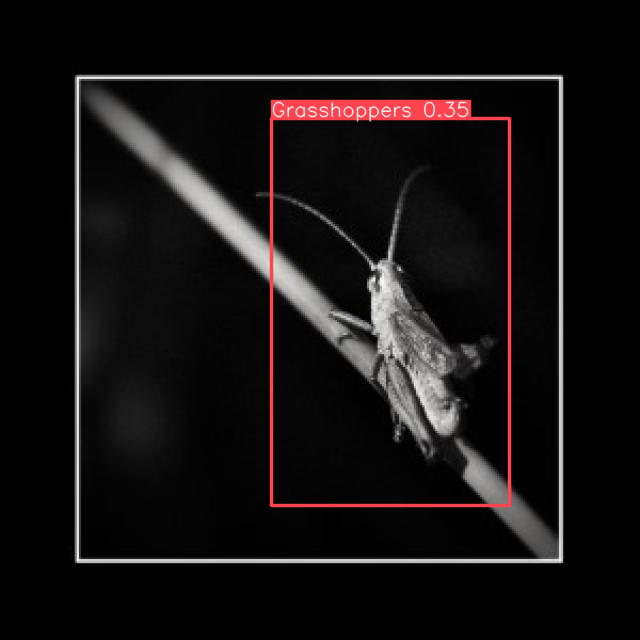

In [ ]:
model = torch.hub.load(
    "ultralytics/yolov5", "custom",
    path="../yolov5/runs/train_1660ti/yolov5s_safe_2/weights/best.pt",
    force_reload=True
)
model.eval()

img = cv2.imread("../data/test/images/grasshopper-70-_jpg.rf.bf6326bd0fbcd038f10cc42a4ae9f88e.jpg") 
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

results = model(
    img_rgb
)

print(results)
results.show() 

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\hi/.cache\torch\hub\master.zip
YOLOv5  v7.0-447-ge76591cb Python-3.11.14 torch-2.3.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)

Fusing layers... 
Model summary: 157 layers, 7042489 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


tensor([[2.71736e+02, 1.18481e+02, 5.09487e+02, 5.05468e+02, 3.46859e-01, 6.00000e+00]], device='cuda:0')
this is cls id 6
[tensor([[[[[ 1.44581e+00, -4.99841e-01,  1.16912e+00,  ..., -2.40881e+00, -2.80733e+00, -2.61871e+00],
           [ 1.40496e+00,  8.88045e-02,  1.76503e+00,  ..., -2.48754e+00, -3.25369e+00, -2.74700e+00],
           [ 1.05634e+00,  2.60926e-01,  1.71510e+00,  ..., -2.72317e+00, -3.43479e+00, -2.35518e+00],
           ...,
           [ 1.02011e+00,  5.60065e-02,  1.70425e+00,  ..., -2.71146e+00, -3.19896e+00, -2.60703e+00],
           [ 9.00418e-01, -9.72157e-02,  1.39619e+00,  ..., -2.28367e+00, -3.17915e+00, -2.65097e+00],
           [-9.49994e-04,  5.21850e-01,  5.69212e-01,  ..., -1.45894e+00, -3.83006e+00, -2.74611e+00]],

          [[ 1.47450e+00, -2.53065e-02,  1.70158e+00,  ..., -3.02803e+00, -2.71938e+00, -2.93199e+00],
           [ 1.46341e+00,  2.77712e-01,  2.00739e+00,  ..., -3.21711e+00, -3.24620e+00, -3.21299e+00],
           [ 1.13159e+00,  4.80643

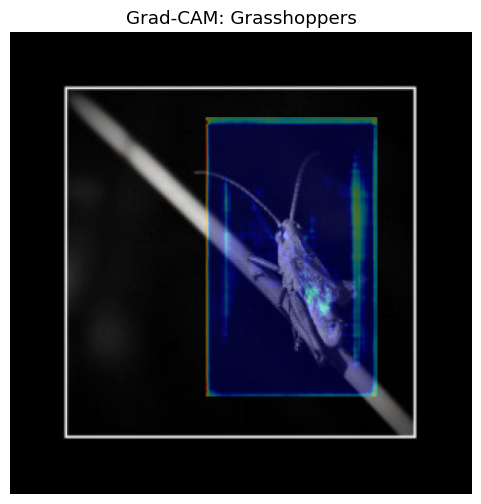

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [ ]:
gradcam_yolov5_ultralytics(img_path="../data/test/images/grasshopper-70-_jpg.rf.bf6326bd0fbcd038f10cc42a4ae9f88e.jpg", show=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\hi/.cache\torch\hub\master.zip
YOLOv5  v7.0-447-ge76591cb Python-3.11.14 torch-2.3.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)

Fusing layers... 
Model summary: 157 layers, 7042489 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


image 1/1: 640x640 1 Grasshoppers
Speed: 5.7ms pre-process, 16.1ms inference, 18.5ms NMS per image at shape (1, 3, 640, 640)


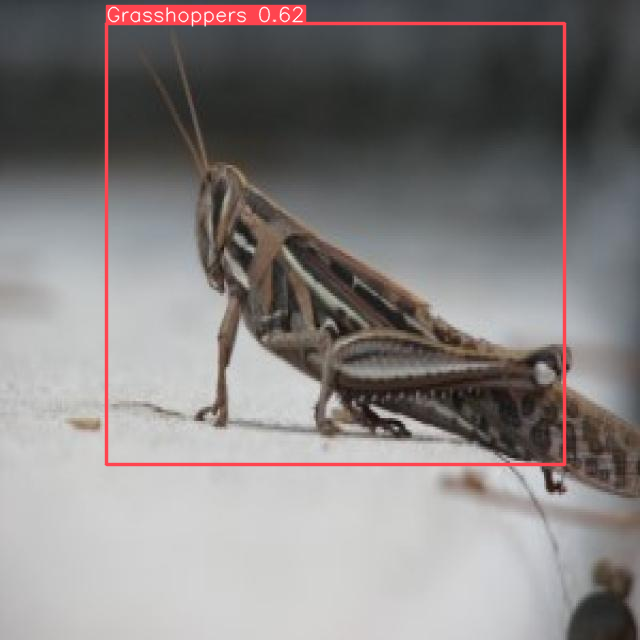

In [ ]:
model = torch.hub.load(
    "ultralytics/yolov5", "custom",
    path="../yolov5/runs/train_1660ti/yolov5s_safe_2/weights/best.pt",
    force_reload=True
)
model.eval()

img = cv2.imread("../data/test/images/grasshopper-463-_jpg.rf.5d8be9d8695d1c5d6d22ff24e397a0dc.jpg") 
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

results = model(
    img_rgb
)

print(results)
results.show()

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\hi/.cache\torch\hub\master.zip
YOLOv5  v7.0-447-ge76591cb Python-3.11.14 torch-2.3.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)

Fusing layers... 
Model summary: 157 layers, 7042489 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


tensor([[106.21204,  23.86382, 564.29504, 464.53625,   0.62428,   6.00000]], device='cuda:0')
this is cls id 6
[tensor([[[[[ 1.42297, -0.61003,  0.96457,  ..., -2.52471, -2.78759, -2.73042],
           [ 1.41607,  0.25134,  1.77399,  ..., -2.51581, -3.26190, -2.85241],
           [ 1.03058,  0.12869,  1.43912,  ..., -2.77141, -3.29411, -2.55715],
           ...,
           [ 1.09711,  0.01805,  1.35996,  ..., -2.65080, -3.18346, -2.41128],
           [ 0.96701, -0.17419,  1.25716,  ..., -2.30321, -3.01853, -2.29406],
           [ 0.26638,  0.29627,  0.58105,  ..., -1.53280, -3.65145, -2.39350]],

          [[ 1.28431,  0.00860,  1.57218,  ..., -3.05355, -2.69959, -3.03380],
           [ 1.23337,  0.42143,  1.98496,  ..., -3.27166, -3.25275, -3.19846],
           [ 0.83201,  0.16561,  1.65744,  ..., -3.65462, -3.19885, -2.90505],
           ...,
           [ 1.14756,  0.44636,  1.51671,  ..., -3.28267, -3.08565, -3.08693],
           [ 0.79389,  0.47976,  1.53881,  ..., -2.78779, -3.087

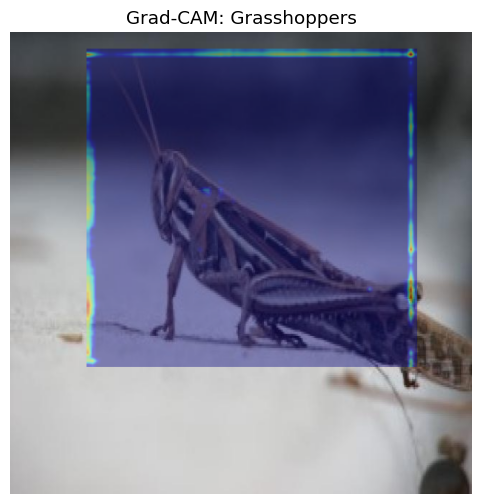

array([[[ 54,  59,  63],
        [ 54,  59,  63],
        [ 54,  59,  63],
        ...,
        [ 64,  65,  67],
        [ 64,  65,  67],
        [ 64,  65,  67]],

       [[ 54,  59,  63],
        [ 54,  59,  63],
        [ 54,  59,  63],
        ...,
        [ 64,  65,  67],
        [ 64,  65,  67],
        [ 64,  65,  67]],

       [[ 55,  60,  64],
        [ 55,  60,  64],
        [ 55,  60,  64],
        ...,
        [ 64,  65,  67],
        [ 64,  65,  67],
        [ 64,  65,  67]],

       ...,

       [[178, 176, 177],
        [178, 176, 177],
        [178, 176, 177],
        ...,
        [ 75,  65,  64],
        [105,  95,  94],
        [104,  94,  93]],

       [[178, 176, 177],
        [178, 176, 177],
        [178, 176, 177],
        ...,
        [ 75,  65,  64],
        [104,  94,  93],
        [103,  93,  92]],

       [[178, 176, 177],
        [178, 176, 177],
        [178, 176, 177],
        ...,
        [ 74,  64,  63],
        [103,  93,  92],
        [103,  93,  92]]

In [ ]:
gradcam_yolov5_ultralytics(img_path="../data/test/images/grasshopper-463-_jpg.rf.5d8be9d8695d1c5d6d22ff24e397a0dc.jpg", show=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\hi/.cache\torch\hub\master.zip
YOLOv5  v7.0-447-ge76591cb Python-3.11.14 torch-2.3.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)

Fusing layers... 
Model summary: 157 layers, 7042489 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


image 1/1: 640x640 (no detections)
Speed: 18.9ms pre-process, 67.6ms inference, 120.7ms NMS per image at shape (1, 3, 640, 640)


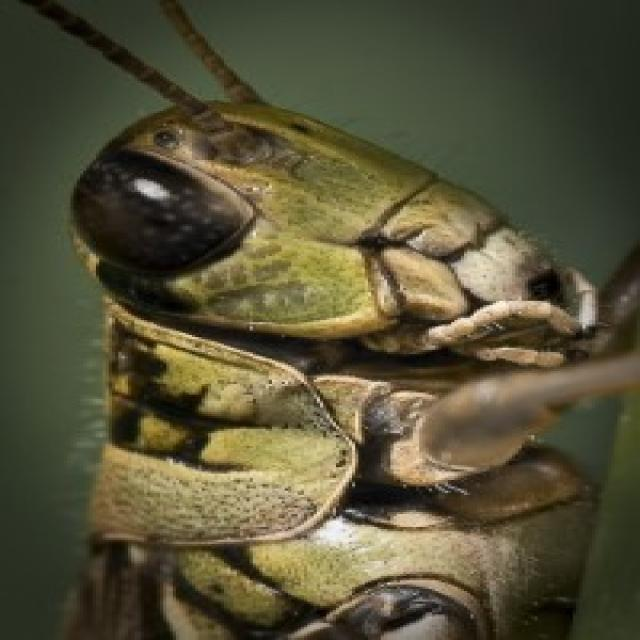

In [ ]:
model = torch.hub.load(
    "ultralytics/yolov5", "custom",
    path="../yolov5/runs/train_1660ti/yolov5s_safe_2/weights/best.pt",
    force_reload=True
)
model.eval()

img = cv2.imread("../data/test/images/grasshopper-448-_jpg.rf.09e215eaa2f2a805e530a5a5d64560b3.jpg") 
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

results = model(
    img_rgb
)

print(results)
results.show() 

In [100]:
gradcam_yolov5_ultralytics(img_path="../data/valid/images/grasshopper-448-_jpg.rf.09e215eaa2f2a805e530a5a5d64560b3.jpg", show=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\hi/.cache\torch\hub\master.zip
YOLOv5  v7.0-447-ge76591cb Python-3.11.14 torch-2.3.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)

Fusing layers... 
Model summary: 157 layers, 7042489 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


tensor([], device='cuda:0', size=(0, 6))
No detections.
